In [14]:
import numpy as np
import matplotlib.pyplot as plt
import keras.datasets.mnist as mnist
from tqdm import tqdm

In [15]:
def one_hot_vector(n, total):
  return np.array([0] * (n) + [1] + [0] * (total-n-1), dtype=np.float64).reshape(total, 1)


def rmse(prediction, real_result):
  return np.sqrt(np.mean(np.square(prediction-real_result)))


# def binary_cross_entropy(p, y):
#   print(y * np.log(p) + (1-y) * np.log(1-p))
#   return -np.sum((y * np.log(p) + (1-y) * np.log(1-p)))


def binary_cross_entropy(p, y):
  return -np.sum(y * np.log(p), axis=0)


In [16]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(len(x_train), 28*28, 1).astype(np.float64)
y_train = np.array(list(map(lambda x: one_hot_vector(x, 10), y_train)))

x_train = (x_train-127.5)/127.5
x_test = x_test.reshape(len(x_test), 28*28, 1).astype(np.float64)
x_test = (x_test-127.5)/127.5
y_test = np.array(list(map(lambda x: one_hot_vector(x, 10), y_test)))

In [17]:
class Activation():
  def forward(self, input):
    pass

  def backward(self, output):
    pass


class Sigmoid(Activation):
  def forward(self, input):
    return 1/(1+np.exp(-input))

  def backward(self, output):
    return output * (1-output)


class Softmax(Activation):
  def forward(self, input):
    return np.exp(input)/sum(np.exp(input))

  def backward(self, output):
    pass


class SoftmaxCrossEntropy(Activation):
  def forward(self, input):
    return Softmax().forward(input)

  def loss(self, input, real_result):
    return binary_cross_entropy(input, real_result)

  def backward(self, output, real_reault):
    return output - real_reault


class NN(object):
  def __init__(self, input, output, hidden, learning_rate, batch, activation_func, final_activation):
    self.network = []
    self.predict = []
    self.layer_count = 0
    self.layer_count = len(hidden) + 2
    self.activation_func = activation_func
    self.learning_rate = learning_rate
    self.batch = batch
    self.final = final_activation

    try:
      assert(isinstance(self.activation_func, Activation))
    except:
      raise Exception("Activation function type error.")

    try:
      assert(isinstance(final_activation, Activation))
    except:
      raise Exception("Final Activation & Loss function type error.")

    self.construct_layers(input, output, hidden)

  def construct_layers(self, n, m, hidden):
    i = 0
    layers = [n]+hidden+[m]
    while i < len(layers) - 1:
      self.network.append(np.random.rand(layers[i+1], layers[i]) - 0.5)
      i += 1

  def evaulate(self, data):
    data = data.squeeze().T
    self.predict = [data.copy()]
    for weight in self.network[:-1]:
      data = self.activation_func.forward(weight.dot(data))
      self.predict.append(data)
    data = self.final.forward(self.network[-1].dot(data))
    self.predict.append(data)
    return data

  def loss(self, evaulated, real_result):
    real_result = real_result.squeeze().T
    return self.final.loss(evaulated, real_result)

  def back_propagation(self, real_result):
    real_result = real_result.squeeze().T
    predict = self.predict.pop()
    gradient = self.final.backward(predict, real_result)
    last_weight = self.network[-1].copy()
    self.network[-1] -= self.learning_rate * gradient.dot(self.predict[-1].T)
    for i in reversed(range(len(self.network) - 1)):
      activation_gradient = self.activation_func.backward(self.predict.pop())
      gradient = last_weight.T.dot(gradient) * activation_gradient
      last_weight = self.network[i].copy()
      self.network[i] -= self.learning_rate * gradient.dot(self.predict[-1].T)

  def train(self, x, y, epoch):
    loss_plt = []
    for _ in range(epoch):
      t = tqdm(range(len(x)//self.batch+1))
      randomize = np.arange(len(x))
      np.random.shuffle(randomize)
      x, y = x[randomize], y[randomize]
      for i in t:
        __x = x[i*self.batch:(i+1)*self.batch]
        __y = y[i * self.batch:(i+1)*self.batch]
        if __x.shape[0] == 0:
          continue
        result = self.evaulate(__x)
        loss = self.loss(result, __y)
        self.back_propagation(__y)
        loss_plt.append(np.median(loss))
        if i % 10 == 0:
          t.set_description(f"Epoch: #{_}, loss: {loss_plt[-1]:.10f}")
    return loss_plt

  def __repr__(self):
    return f"<NN layer: {self.layer_count}>"


In [18]:
nn = NN(
    input=28*28,
    output=10,
    hidden=[28*28, 600, 500, 300, 100, 50],
    learning_rate=5e-3,
    batch=100,
    activation_func=Sigmoid(),
    final_activation=SoftmaxCrossEntropy()
)

Epoch: #19, loss: 0.0001022917: 100%|██████████| 601/601 [00:18<00:00, 32.30it/s]


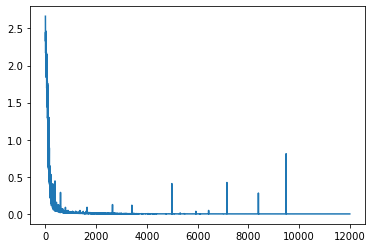

In [19]:
loss = nn.train(x_train, y_train, 20)
plt.plot(loss)

array([6.81839756e-07, 9.99532785e-01, 9.43667825e-07, 2.30001072e-05,
       1.54057656e-04, 1.93319643e-06, 3.84722935e-06, 2.73287444e-04,
       2.27255056e-06, 7.19086071e-06])

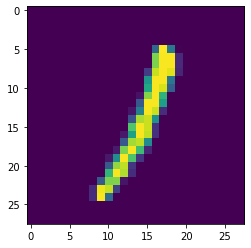

In [22]:
i = 99
plt.imshow(x_train[i].reshape(28, 28))
result = nn.evaulate(x_train[i:i+1])
result

In [23]:
correct = 0

for x, y in zip(x_test, y_test):
  result = nn.evaulate(x)
  if np.where(y == 1)[0] == np.where(result == np.amax(result))[0][0]:
    correct += 1

print("Accuracy", correct/len(x_test))

Accuracy 0.9747
